In [46]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import market penetration data for December 2017.  Deal with thousands comma and * for null values
#note: counties with less than 10 enrollees have * for enrollment
#note: link to data: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/MA-State-County-Penetration-Items/MA-State-County-Penetration-2017-12.html?DLPage=2&DLEntries=10&DLSort=1&DLSortDir=descending

data_types = {'FIPSST': object, 
              'FIPSCNTY': object, 
              'FIPS': object, 
              'SSAST': object, 
              'SSACNTY': object, 
              'SSA': object
             }

pen_df = pd.read_csv('data/State-County-Penetration-MA-2017-12/State_County_Penetration_MA_2017_12.csv', \
                     dtype=data_types, thousands=r',', na_values=["*"])

#remove spaces from column names
pen_df.columns = pen_df.columns.map(lambda x: x.replace(' ', '_') if isinstance(x, (str)) else x)

#rename some columns to make clear
pen_df.rename(columns={'Enrolled':'pop_Enrolled','Penetration':'pop_Penetration'}, inplace=True)
pen_df.head()

,State_Name,County_Name,FIPSST,FIPSCNTY,FIPS,SSAST,SSACNTY,SSA,Eligibles,pop_Enrolled,pop_Penetration
0,Alabama,Autauga,01,001,01001,01,000,01000,10792,4803.0,44.51%
1,Alabama,Baldwin,01,003,01003,01,010,01010,50168,21010.0,41.88%
2,Alabama,Barbour,01,005,01005,01,020,01020,6441,1909.0,29.64%
3,Alabama,Bibb,01,007,01007,01,030,01030,4954,2381.0,48.06%
4,Alabama,Blount,01,009,01009,01,040,01040,12564,6363.0,50.64%


In [47]:
# prepping a subset of penetration data for analysis
pen_df2 = pen_df[['FIPS','Eligibles','pop_Enrolled']].copy() #copy to prevent SettingWithCopyWarning

#recalculate penetration rates
pen_df2['pop_Penetration'] = pen_df2['pop_Enrolled'] / pen_df2['Eligibles']
pen_df2.head()



,FIPS,Eligibles,pop_Enrolled,pop_Penetration
0,01001,10792,4803.0,0.445052
1,01003,50168,21010.0,0.418793
2,01005,6441,1909.0,0.296383
3,01007,4954,2381.0,0.480622
4,01009,12564,6363.0,0.506447


In [42]:
# loading and cleaning MA plan enrollemnt realted data (December 2017)
#note: link to data: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/Monthly-MA-Enrollment-by-State-County-Contract-Items/MA-Enrollment-by-SCC-2017-12-new.html?DLPage=2&DLEntries=10&DLSort=1&DLSortDir=descending
data_types = {
              'FIPS Code': object,
              'SSA Code': object
             }

#import market penetration data for December 2017.  Deal with thousands comma and * for null values
#note: plans with less than 10 enrollees in a county have * for enrollment
plan = pd.read_csv('data/SCC-Enrollment-MA-2017-12/SCC_Enrollment_MA_2017_12.csv', \
                     dtype=data_types, thousands=r',', na_values=["*"])

cols = plan.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str)) else x)
plan.columns = cols
plan.rename(columns={'Enrolled':'plan_Enrolled'}, inplace=True)
plan.head()


,County,State,Contract_ID,Organization_Name,Organization_Type,Plan_Type,SSA_Code,FIPS_Code,plan_Enrolled
0,Autauga,AL,H0104,BLUE CROSS AND BLUE SHIELD OF ALABAMA,Local CCP,Local PPO,01000,01001,1062.0
1,Autauga,AL,H0107,HEALTH CARE SERVICE CORPORATION,Local CCP,Local PPO,01000,01001,NaN
2,Autauga,AL,H0150,"HEALTHSPRING OF ALABAMA, INC.",Local CCP,HMO/HMOPOS,01000,01001,565.0
3,Autauga,AL,H0154,"VIVA HEALTH, INC.",Local CCP,HMO/HMOPOS,01000,01001,1452.0
4,Autauga,AL,H0504,CALIFORNIA PHYSICIANS' SERVICE,Local CCP,HMO/HMOPOS,01000,01001,NaN


In [70]:
#grouping of contracts for one county by org name.  
plan[(plan['FIPS_Code'] == '01001') & (plan['plan_Enrolled'] > 0)].groupby('Organization_Name')['plan_Enrolled'].sum().sort_values(ascending=False)



Organization_Name
VIVA HEALTH, INC.                                 1452.0
BLUE CROSS AND BLUE SHIELD OF ALABAMA             1062.0
UNITEDHEALTHCARE OF THE MIDLANDS, INC.             864.0
HEALTHSPRING OF ALABAMA, INC.                      565.0
SIERRA HEALTH AND LIFE INSURANCE COMPANY, INC.     554.0
HUMANA INSURANCE COMPANY                           268.0
AETNA LIFE INSURANCE COMPANY                        15.0
BCBS OF MICHIGAN MUTUAL INSURANCE COMPANY           13.0
Name: plan_Enrolled, dtype: float64

In [44]:
# Note any plans with fewer than 10 enrollees in a county had the data redacted for privacy purposes.  For this reason
# we have NaN values for certain plan/ county pairs.  We may choose to fill these with 0 to aid analysis.  This should
# be noted as an assumption.
plan = plan.fillna(0)


In [48]:
# merging two datasets
plan_pen_merge = pd.merge(plan, pen_df2, how="left", left_on='FIPS_Code', right_on='FIPS')
plan_pen_merge.head()

,County,State,Contract_ID,Organization_Name,Organization_Type,Plan_Type,SSA_Code,FIPS_Code,plan_Enrolled,FIPS,Eligibles,pop_Enrolled,pop_Penetration
0,Autauga,AL,H0104,BLUE CROSS AND BLUE SHIELD OF ALABAMA,Local CCP,Local PPO,01000,01001,1062.0,01001,10792.0,4803.0,0.445052
1,Autauga,AL,H0107,HEALTH CARE SERVICE CORPORATION,Local CCP,Local PPO,01000,01001,0.0,01001,10792.0,4803.0,0.445052
2,Autauga,AL,H0150,"HEALTHSPRING OF ALABAMA, INC.",Local CCP,HMO/HMOPOS,01000,01001,565.0,01001,10792.0,4803.0,0.445052
3,Autauga,AL,H0154,"VIVA HEALTH, INC.",Local CCP,HMO/HMOPOS,01000,01001,1452.0,01001,10792.0,4803.0,0.445052
4,Autauga,AL,H0504,CALIFORNIA PHYSICIANS' SERVICE,Local CCP,HMO/HMOPOS,01000,01001,0.0,01001,10792.0,4803.0,0.445052


In [49]:
plan_pen_merge.groupby(['FIPS_Code', 'pop_Enrolled'])['plan_Enrolled'].sum()

FIPS_Code  pop_Enrolled
01001      4803.0           4793.0
01003      21010.0         20920.0
01005      1909.0           1894.0
01007      2381.0           2361.0
01009      6363.0           6347.0
01011      726.0             695.0
01013      1014.0            994.0
01015      6950.0           6908.0
01017      2243.0           2211.0
01019      2273.0           2262.0
01021      5082.0           5070.0
01023      676.0             657.0
01025      2440.0           2426.0
01027      907.0             888.0
01029      713.0             688.0
01031      2013.0           1999.0
01033      3147.0           3131.0
01035      781.0             772.0
01037      631.0             621.0
01039      1824.0           1790.0
01041      1237.0           1220.0
01043      6668.0           6647.0
01045      1892.0           1880.0
01047      3124.0           3096.0
01049      4332.0           4303.0
01051      6474.0           6449.0
01053      2829.0           2806.0
01055      9523.0           950

In [42]:
#as you can see, some of the plan statistics are NaN and missing the the summary below.
plan_pen_merge['Organization_Type'].value_counts()

Local CCP           323265
PFFS                  8194
Regional CCP          4588
Demo                  4489
HCPP - 1833 Cost      3984
1876 Cost             1768
National PACE         1070
MSA                    204
Name: Organization_Type, dtype: int64

In [33]:
#Below are the counties with NaN values for the FIPS variable.  These seem to be US territories not states,
# so shouldn't impact analysis.
plan_pen_merge[plan_pen_merge['FIPS'].isnull()].groupby('State')['FIPS_Code'].value_counts()

State  FIPS_Code
AK     0            189
       02230         93
       02270         93
AS     60050         50
       60010         40
       60020         40
       60040          8
GU     66010        520
HI     15005         95
MP     69085         12
SD     46113         95
VA     51560          1
       51780          1
Name: FIPS_Code, dtype: int64

In [34]:
# add new vaiables for plan market share and penetration
plan_pen_merge['plan_penetration'] = plan_pen_merge.plan_Enrolled / plan_pen_merge.Eligibles
plan_pen_merge['plan_mkt_share'] = plan_pen_merge.plan_Enrolled / plan_pen_merge.pop_Enrolled


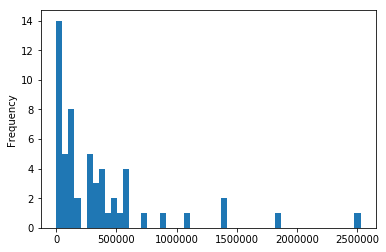

In [37]:
plan_pen_merge.groupby('State')['plan_Enrolled'].sum().plot.hist(bins=50)

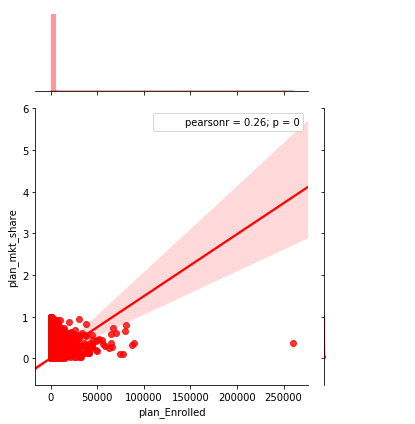

In [77]:
#Linear regression with marginal distributions
g = sns.jointplot("plan_Enrolled", "plan_mkt_share", data=plan_pen_merge, kind="reg", ratio=3, color="r")

In [38]:
# Assigning numerical and categorical variables for analysis and visualization
numerical =['pop_Enrolled', 'pop_Enrolled','pop_Penetration', 'plan_penetration', 'plan_mkt_share' ]
categorical = ['County', 'State','Organization_Name', 'Organization_Type', 'Plan_Type', 'SSA_Code', 'FIPS_Code' ]


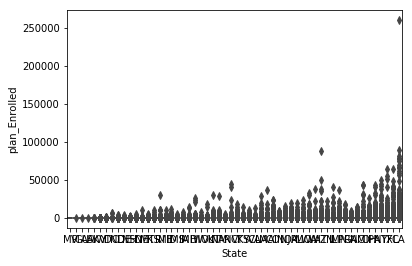

In [39]:
sorted_nb = plan_pen_merge.groupby(['State'])['plan_Enrolled'].sum().sort_values()
sns.boxplot(x=plan_pen_merge['State'], y=plan_pen_merge['plan_Enrolled'], order=list(sorted_nb.index))

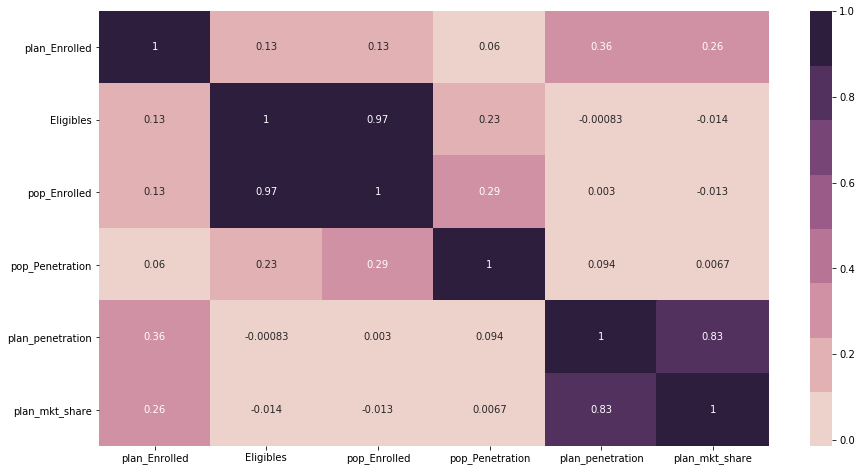

In [41]:
#Simple plot of correlation between variables

plt.figure(figsize=(15,8))
sns.heatmap(plan_pen_merge.corr(),cmap=sns.cubehelix_palette(8), annot=True)

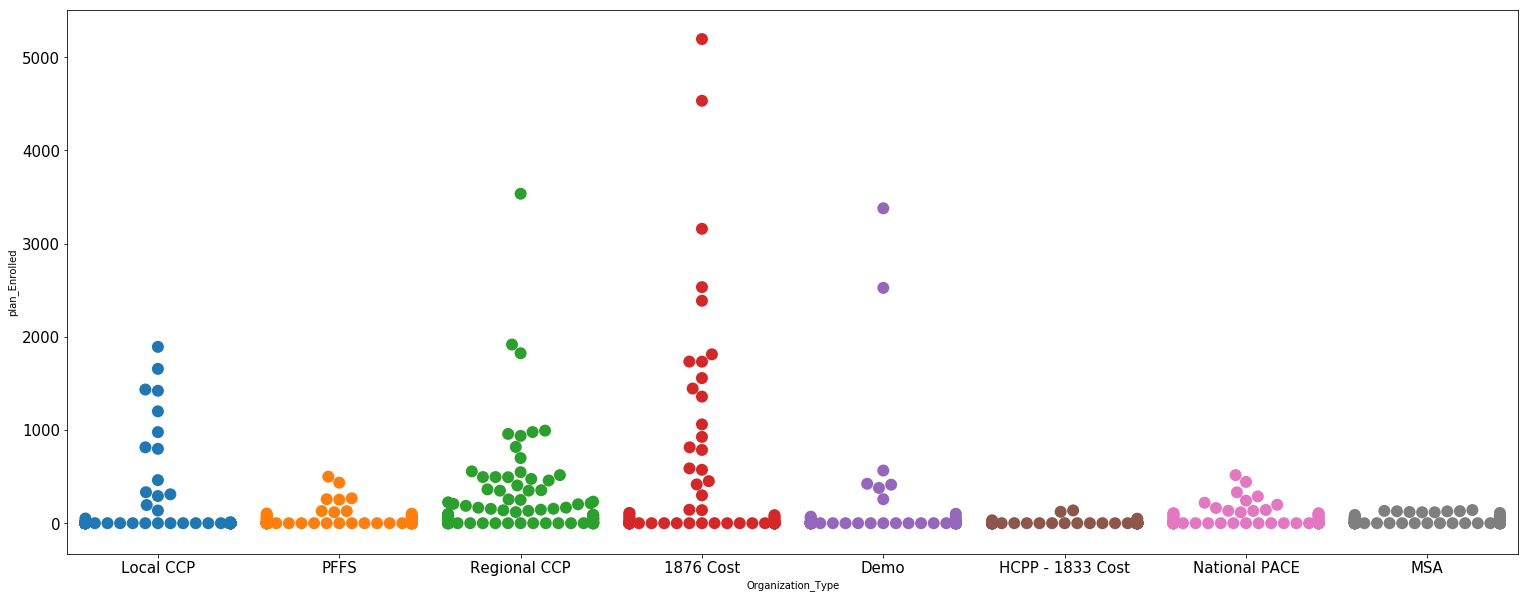

In [44]:
samp = plan_pen_merge.sample(frac=1.0).groupby(['Plan_Type']).head(100)

plt.figure(figsize=(26,10))
g = sns.swarmplot(x='Organization_Type', y='plan_Enrolled', 
                  data=samp, size=12)

g.tick_params(labelsize=15, )

In [64]:
#count of unique plans in each county, by county.
p_co = plan_pen_merge[['County', 'State', 'Contract_ID','Organization_Name','FIPS']]
p_co[p_co['FIPS'] == '01001'].groupby('FIPS')["Organization_Name"].value_counts()

# plan_pen_merge.groupby("Organization_Name")
# plan_pen_merge.groupby('FIPS').nunique('Contract_ID')

FIPS   Organization_Name                                 
01001  ANTHEM INSURANCE COMPANIES, INC.                      4
       AETNA HEALTH INC. (PA)                                3
       HUMANA INSURANCE COMPANY                              3
       AMERICAN PROGRESSIVE LIFE & HLTH INS COMPANY OF NY    2
       BCBS OF MICHIGAN MUTUAL INSURANCE COMPANY             2
       CARE N' CARE INSURANCE COMPANY, INC.                  2
       HEALTH ALLIANCE - MIDWEST, INC.                       2
       HEALTH CARE SERVICE CORPORATION                       2
       HORIZON INSURANCE COMPANY                             2
       MARTIN'S POINT GENERATIONS ADVANTAGE, INC.            2
       PRIORITY HEALTH                                       2
       SIERRA HEALTH AND LIFE INSURANCE COMPANY, INC.        2
       UNITEDHEALTHCARE INSURANCE COMPANY                    2
       AETNA HEALTH INC. (CT)                                1
       AETNA HEALTH INC. (FL)                               

In [17]:
import plotly.plotly as py
import plotly.figure_factory as ff

fips = ['06021', '06023', '06027',
        '06029', '06033', '06059',
        '06047', '06049', '06051',
        '06055', '06061']
values = range(len(fips))

fig = ff.create_choropleth(fips=fips, values=values)
py.iplot(fig, filename='choropleth of some cali counties - full usa scope')

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
pip install geopandas==0.3.0
pip install pyshp==1.2.10
pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
conda install plotly
conda install geopandas
```

In [20]:
import geopandas
geopandas.__version

ImportError: dlopen(/Users/lovejoy/anaconda3/lib/python3.6/site-packages/fiona/ogrext.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libssl.1.0.0.dylib
  Referenced from: /Users/lovejoy/anaconda3/lib/libgdal.20.dylib
  Reason: image not found